In [69]:
!sox test.wav -s2L test.raw
!sox test2.wav -s2L test2.raw

In [100]:
from pylab import *
test = numpy.fromfile("test.raw","int32")
test2 = numpy.fromfile("test2.raw","int32")

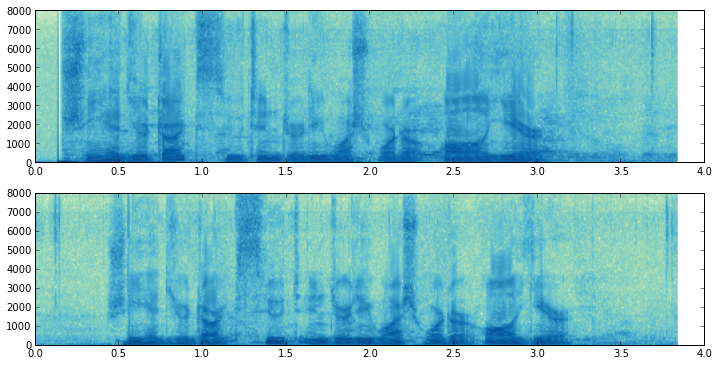

In [101]:
figsize(12,6)
subplot(211)
_=specgram(1.0*test,NFFT=256,noverlap=128,Fs=16000,cmap=cm.GnBu,sides='onesided')
subplot(212)
_=specgram(1.0*test2,NFFT=256,noverlap=128,Fs=16000,cmap=cm.GnBu,sides='onesided')

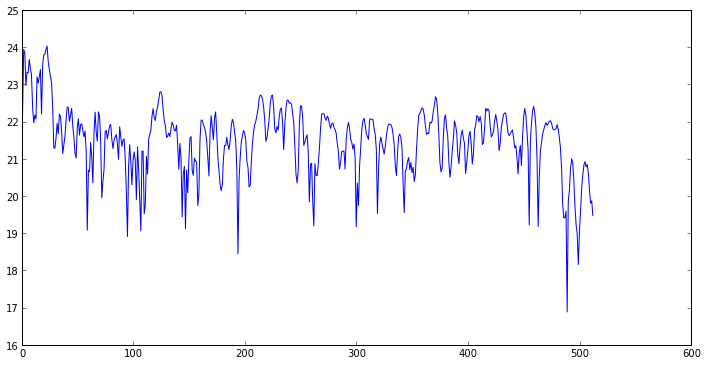

In [102]:
def windowed_spec(data):
    n = len(data)
    w = (arange(n)-n/2.0)**2
    w /= amax(w)
    w = 1-w
    return log(abs(fft(w*data)))[:n//2]
plot(windowed_spec(test[20000:21024]))

In [103]:
def spectrogram(signal,nfft=256,step=128):
    return array([windowed_spec(signal[i:i+nfft]) for i in range(0,len(signal)-nfft,step)])

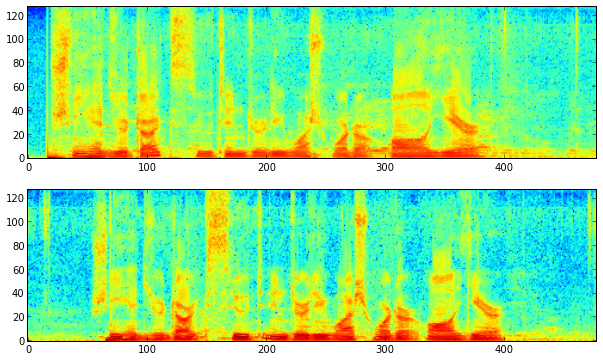

In [104]:
spec1 = spectrogram(test)
spec1 /= amax(spec1)
spec2 = spectrogram(test2)
spec2 /= amax(spec2)
subplot(211); imshow(spec1.T,origin='lower')
subplot(212); imshow(spec2.T,origin='lower')

In [105]:
norm(spec1[100]-spec2[50])

1.1555903330288289

In [106]:
n1,n2 = len(spec1),len(spec2)
costs = 1e9*ones((n1,n2))
costs[0,0] = 0
sources = empty((n1,n2),'object')
sources[:,:] = None
alpha = 0.3

queue = [(0,0)]

while len(queue)>0:
    i,j = queue.pop(0)
    assert i<n1 and j<n2
    if i<n1-1 and j<n2-1:
        c = norm(spec1[i+1]-spec2[j+1])
        if costs[i+1,j+1]>costs[i,j]+c:
            costs[i+1,j+1] = costs[i,j]+c
            sources[i+1,j+1] = (i,j)
            queue.append((i+1,j+1))
    if i<n1-1:
        c = norm(spec1[i+1]-spec2[j])+alpha
        if costs[i+1,j]>costs[i,j]+c:
            costs[i+1,j] = costs[i,j]+c
            sources[i+1,j] = (i,j)
            queue.append((i+1,j))
    if j<n2-1:
        c = norm(spec1[i]-spec2[j+1])+alpha
        if costs[i,j+1]>costs[i,j]+c:
            costs[i,j+1] = costs[i,j]+c
            sources[i,j+1] = (i,j)
            queue.append((i,j+1))

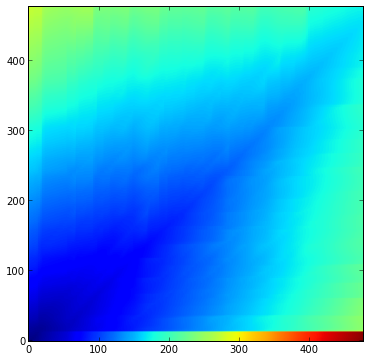

In [107]:
figsize(6,6)
imshow(where(costs<1e8,costs,0),origin='lower')

In [108]:
path = []
i,j = (n1-1,n2-1)
while 1:
    assert i<n1 and j<n2
    path.append((i,j))
    if i==0 and j==0: break
    i,j = sources[i,j]
path = array(path)[::-1]

In [109]:
aligned = (n2-1)*ones(n1,'i')
for i,j in path:
    assert j<n2
    aligned[i] = j

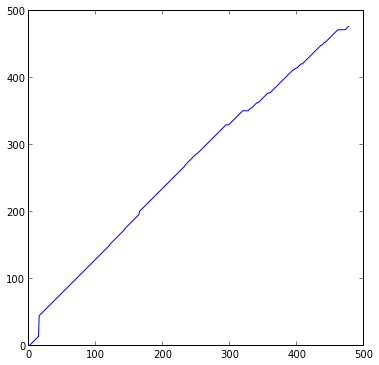

In [110]:
plot(aligned)

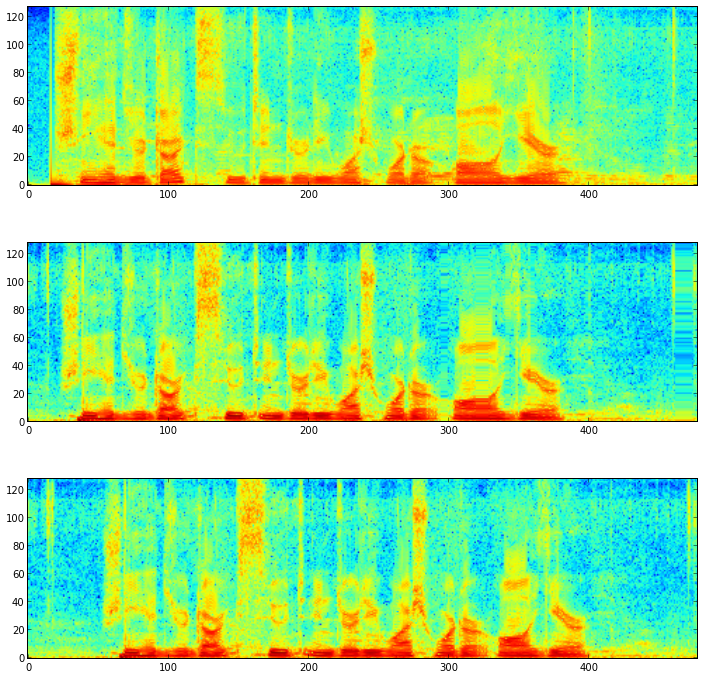

In [111]:
figsize(12,12)
subplot(311); imshow(spec1.T,origin='lower')
subplot(312); imshow(spec2[aligned].T,origin='lower')
subplot(313); imshow(spec2.T,origin='lower')